# Class Workbook

## In class activity

In [55]:
import numpy as np
import pandas as pd
import math
#import statsmodels.api as sm
from plotnine import *
import statsmodels.formula.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize ,
                        poly)
from statsmodels.discrete.discrete_model import Logit

### Ames House Data

In [12]:
ames_raw=pd.read_csv("ames_raw.csv")

Let's revisit the AmesHousing data.  As we did in the previous class, I will split the data into before 2008 and after.  The data up to 2008 will be the training data and after 2008 will be the testing data.

In [5]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

* For the regression model fit, use bootstrap to compare the standard error estimates to the model based estimates.

Your code:

In [30]:
from functools import partial
import statsmodels.api as sm
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
def boot_OLS(model_matrix, response, D, idx):
    D_ = D.loc[idx]
    Y_ = D_[response]
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.OLS(Y_, X_).fit().params
ames_raw_2008.reset_index(drop=True, inplace=True)
MS = ColumnTransformer([
    ('scale', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area'])
])
hp_func = partial(boot_OLS, MS, 'SalePrice')  
rng = np.random.default_rng(0)
sample_size = len(ames_raw_2008)  
np.array([hp_func(ames_raw_2008,
          rng.choice(sample_size,
                     sample_size,
                     replace=True)) for _ in range(10)])
hp_se = boot_SE(hp_func,
                ames_raw_2008,
                B=1000,
                seed=10)
hp_se

x1    2031.065626
x2    3547.963073
x3    3429.825531
x4    3388.310915
dtype: float64

Your answer:

~~~
x1    2031.065626
x2    3547.963073
x3    3429.825531
x4    3388.310915
~~~


* Use cross validation  to decide which model has a good predictive accuracy.  Does the result hold true for the prediction of future data?

Your code:

In [34]:
from ISLP.models import sklearn_sm
from sklearn.model_selection import cross_validate
 
hp_model = sklearn_sm(sm.OLS,
                      MS)
X, Y = ames_raw_2008.drop(columns=['SalePrice']), ames_raw_2008['SalePrice']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=ames_raw_2008.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

35318417215.350914

Your answer:
~~~
Yes.
~~~


Using `knn.reg` fit KNN regression model.  Use cross validation to decide which K to use.

Your code:

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
ames_data = ames_raw_2008.select_dtypes(include=[np.number]).dropna()

X_train_ames = ames_data.drop('SalePrice', axis=1) 
y_train_ames = ames_data['SalePrice']
k_range = list(range(1, 31))
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])e
param_grid = {'knn__n_neighbors': k_range}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_ames, y_train_ames)
best_k_ames = grid_search.best_params_['knn__n_neighbors']
best_score_ames = grid_search.best_score_

print(f"Best K for Ames dataset: {best_k_ames}")
print(f"Best Cross-Validation Score (MSE) for Ames dataset: {best_score_ames}")


Best K for Ames dataset: 8
Best Cross-Validation Score (MSE) for Ames dataset: -1682015189.3728452




* Which model performs better on your training data?  Which model performs better in your future prediction?



Your answer:

~~~
KNN-regression.
~~~

## Problem Set

### Bootstrap

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We first create an array store with values that will subsequently
be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap
sample.

We will investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time
we record whether or not the fourth observation is contained in the bootstrap sample.

Here is the code to get you going

In [44]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0


np.mean(store)

0.6362

Comment on the results obtained.


Your answer:

~~~
The mean value obtained is 0.6362, indicating that in approximately 63.62% of the trials, the number 4 was selected at least once when drawing 100 numbers between 0 and 99 with replacement.


~~~

### CV

We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:

In [45]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.


Your answer:

~~~
n=100,p=2
Y=X-2X^2
~~~


(b) Create a scatterplot of X against Y . Comment on what you find.


Your code:

<Axes: >

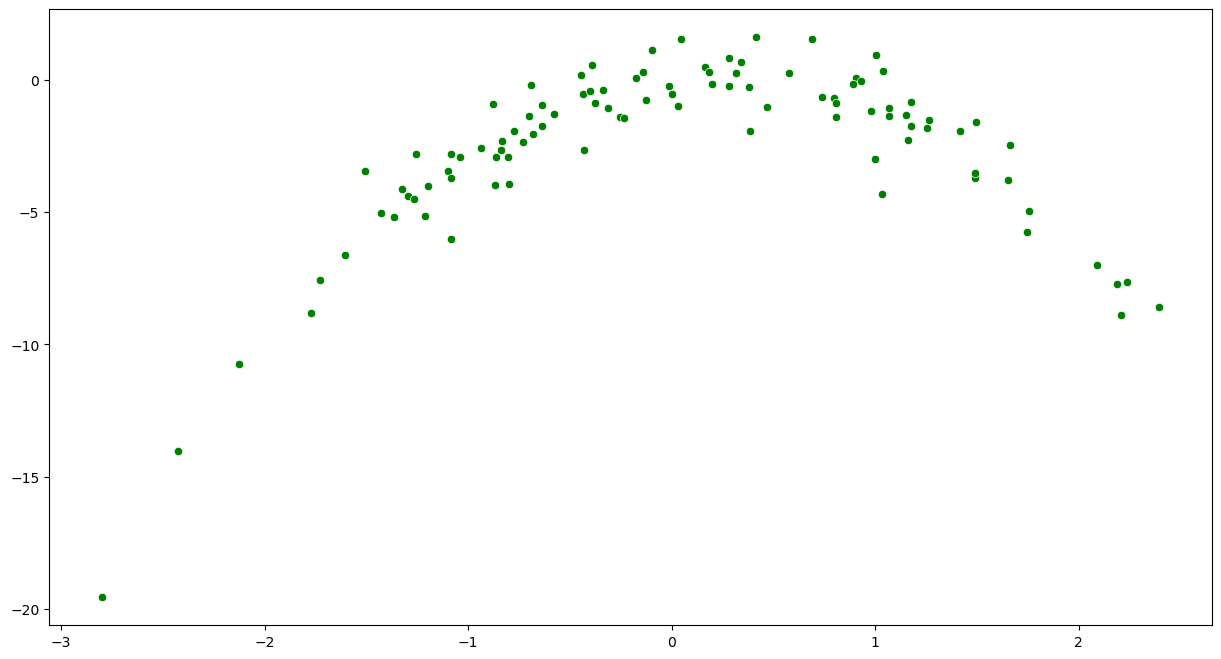

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(15, 8))
sns.scatterplot(x=x, y=y, color='g')


(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i.   $Y = \beta_0 + \beta_1X + \epsilon$
ii.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
iv.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$.

Note you may find it helpful to use the `data.frame()` function
to create a single data set containing both $X$ and $Y$ .


Your code:

In [51]:
import random
from sklearn.linear_model import LinearRegression

def LOOCV(df):
    n = len(df)
    error = 0.0

    for i in range(n):
        test = df.iloc[[i]]
        train = df.drop(df.index[i])

        X_ = train.loc[:, train.columns != 'y']
        y_ = train['y']

        model = LinearRegression(fit_intercept=True)
        model.fit (X_, y_)

        X_ = test.loc[:, df.columns != 'y']
        predictions = model.predict(X_)
        error += (predictions - test.iloc[0]['y'])**2

    return (error/n)

random.seed(123)
df = pd.DataFrame({'x':x, 'y':y})
print("1: " +str(LOOCV(df)))
df = pd.DataFrame({'x':x, 'x2':x**2, 'y':y})
print("2: " +str(LOOCV(df)))
df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'y':y})
print("3: " +str(LOOCV(df)))
df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'y':y})
print("4: " +str(LOOCV(df)))
df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'y':y})
print("5: " +str(LOOCV(df)))
df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'x6':x**6, 'y':y})
print("6: " +str(LOOCV(df)))
df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'x6':x**6, 'x7':x**7, 'y':y})
print("7: " +str(LOOCV(df)))

1: [10.89688257]
2: [0.99317809]
3: [1.03054358]
4: [1.03264901]
5: [0.99922833]
6: [1.01720989]
7: [1.0633692]


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

Your code:

In [52]:
random.seed(123)
df = pd.DataFrame({'x':x, 'y':y})
print("1: " +str(LOOCV(df)))

df = pd.DataFrame({'x':x, 'x2':x**2, 'y':y})
print("2: " +str(LOOCV(df)))

df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'y':y})
print("3: " +str(LOOCV(df)))

df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'y':y})
print("4: " +str(LOOCV(df)))

df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'y':y})
print("5: " +str(LOOCV(df)))

df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'x6':x**6, 'y':y})
print("6: " +str(LOOCV(df)))

df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'x6':x**6, 'x7':x**7, 'y':y})
print("7: " +str(LOOCV(df)))

1: [10.89688257]
2: [0.99317809]
3: [1.03054358]
4: [1.03264901]
5: [0.99922833]
6: [1.01720989]
7: [1.0633692]


Your answer:

~~~
The result is same.


~~~

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.


Your answer:

~~~
Model 5 had the lowest LOOCV error. It's not we expected, since its different to the data we generated.
~~~


(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?


Your code:

In [54]:
df = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4,'x5':x**5, 'y':y})

X_ = df.loc[:, df.columns != 'y']
X_ = sm.add_constant(X_, prepend=True)
y_ = df['y']

model = sm.OLS(y_, X_)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     203.9
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           7.72e-49
Time:                        19:41:26   Log-Likelihood:                -137.22
No. Observations:                 100   AIC:                             286.4
Df Residuals:                      94   BIC:                             302.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0455      0.167     -0.272      0.7

Your answer:

~~~
Yes.
~~~

### Default 1

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default.

Your code:

In [62]:
Default = load_data('Default')

In [61]:
import statsmodels.api as sm
Default['student'] = Default['student'].map({'Yes': 1, 'No': 0})
Default['default'] = Default['default'].map({'Yes': 1, 'No': 0})
X = Default[['income', 'balance']]
X = sm.add_constant(X, prepend=True)
y = Default['default']

model = Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                  0.4594
Time:                        19:45:38   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99

(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

Your code:

In [64]:
train, validation = train_test_split(Default, test_size=0.5)


ii. Fit a multiple logistic regression model using only the training observations.

Your code:

In [71]:
Default['student'] = Default['student'].map({'Yes': 1, 'No': 0})
Default['default'] = Default['default'].map({'Yes': 1, 'No': 0})
X = Default[['income', 'balance']]
X = sm.add_constant(X, prepend=True)
y = Default['default']

model = Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10





iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


Your code:

In [72]:
X_val = validation[['income', 'balance']]
X_val = sm.add_constant(X_val, prepend=True)
predictions = result.predict(X_val) > 0.5



iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

Your code:

In [77]:
len(validation['default']) - np.sum(predictions == validation['default']) / (len(validation['default']))

5000.0

(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.


Your code:

In [80]:
for i in range(3):
    train, validation = train_test_split(Default, test_size=0.5)

    X = train[['income', 'balance']]
    X = sm.add_constant(X, prepend=True)
    y = train['default']

    model = Logit(y, X)
    result = model.fit()

    X_val = validation[['income', 'balance']]
    X_val = sm.add_constant(X_val, prepend=True)
    predictions = result.predict(X_val) > 0.5

    print(len(validation['default']) - np.sum(predictions == validation['default']) / (len(validation['default']))

Optimization terminated successfully.
         Current function value: 0.077290
         Iterations 10
4999.0282
Optimization terminated successfully.
         Current function value: 0.075649
         Iterations 10
4999.028
Optimization terminated successfully.
         Current function value: 0.082536
         Iterations 10
4999.025


Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.


Your code:

In [82]:
train, validation = train_test_split(Default, test_size=0.5)
X = train[['income', 'balance', 'student']]
X = sm.add_constant(X, prepend=True)
y = train['default']
model = Logit(y, X)
result = model.fit()
print(result.summary())
X_val = validation[['income', 'balance', 'student']]
X_val = sm.add_constant(X_val, prepend=True)
predictions = result.predict(X_val) > 0.5
print(len(validation['default']) - np.sum(predictions == validation['default']) / (len(validation['default'])))

Optimization terminated successfully.
         Current function value: 0.086878
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                  0.4223
Time:                        21:56:02   Log-Likelihood:                -434.39
converged:                       True   LL-Null:                       -751.93
Covariance Type:            nonrobust   LLR p-value:                2.512e-137
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.1266      0.644    -15.734      0.000     -11.388      -8.865
income      4.425e-06   1.12

### Default 2

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.

(a) Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
Your code:

In [84]:
X = Default[['income', 'balance']]
y = Default['default']
model = Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.173456
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                 -0.1878
Time:                        22:02:15   Log-Likelihood:                -1734.6
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
income        -0.0001    3.7e-06    -34.025      0.000      -0.000      -0.000
balance        0.0004   7.03e


(b) Write a function, `boot_fn()`, that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.

Your code:

In [85]:
def boot(df):
    return resample(df)
train = boot(Default)
X = train[['income', 'balance']]
X = sm.add_constant(X, prepend=True)
y = train['default']
model = Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.072987
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                  0.4732
Time:                        22:07:20   Log-Likelihood:                -729.87
converged:                       True   LL-Null:                       -1385.5
Covariance Type:            nonrobust   LLR p-value:                1.925e-285
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.2278      0.473    -25.841      0.000     -13.155     -11.300
income      2.595e-05   5.18



(c) Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression
coefficients for income and balance.


Your code:

In [88]:
B = 1000

intercept = []
income = []
balance = []

for i in range(B):
    train = boot(Default)
    X = train[['income', 'balance']]
    X = sm.add_constant(X, prepend=True)
    y = train['default']

    model = Logit(y, X)
    result = model.fit(disp=False)
    intercept.append(result.params.const)
    income.append(result.params.income)
    balance.append(result.params.balance)
print(np.std(intercept, ddof=1))
print(np.std(income, ddof=1))
print(np.std(balance, ddof=1))

0.4398690196035624
4.711703192890295e-06
0.00023279297559966792



(d) Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

Your answer:

~~~
The two way's standard errors are similiar.


~~~

### Boston housing data set

We will now consider the Boston housing data set, from the ISLR library.

In [93]:
boston = load_data("Boston")

(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat{\mu}$.

Your code:

In [94]:
boston['medv'].mean()

22.532806324110677


(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

Your code:

In [96]:
boston['medv'].std()/(len(boston)**0.5)

0.4088611474975351


(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

Your code:

In [98]:
sample_mean = []

for i in range(1000):
    df = resample(boston)
    sample_mean.append(df['medv'].mean())
print(np.std(sample_mean))

0.39436418996493094


Your answer:

~~~
the estimate from bootstrap is close to the answer from (b).


~~~

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence
interval for the mean of medv. Compare it to the results
obtained by using `Boston['medv'].std()` and the two standard
error rule (3.9).
Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} − 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$.

Your code:

In [103]:
print("bootstrap","[",np.mean(sample_mean)-2*np.std(sample_mean),",",np.mean(sample_mean)+2*np.std(sample_mean),"]")
print("original","[",boston['medv'].mean()-2*boston['medv'].std()/(len(boston)**0.5),",",boston['medv'].mean()+2*boston['medv'].std()/(len(boston)**0.5),"]")


bootstrap [ 21.743505809793458 , 23.32096256965318 ]
original [ 21.715084029115605 , 23.35052861910575 ]



(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of medv in the population.

Your code:

In [104]:
boston['medv'].median()

21.2


(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

Your code:

In [105]:
sample_median = []

for i in range(1000):
    df = resample(boston)
    sample_median.append(df['medv'].median())
print(np.std(sample_median))

0.3889678649965826



(g) Based on this data set, provide an estimate for the tenth percentile
of medv in Boston census tracts. Call this quantity $\hat{\mu}_{0.1}$.
(You can use the `np.percentile()` function.)

Your code:

In [106]:
boston['medv'].quantile(q=0.1)

12.75


(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

Your code:

In [107]:
sample_percentile = []

for i in range(1000):
    df = resample(boston)
    sample_percentile.append(df['medv'].quantile(q=0.1))
np.std(sample_percentile)

0.4959587785290224

## Additional Material

### Cross Validation for Predictive Modeling Platforms in Python

#### scikit-learn

Using platforms like scikit-learn is helpful for things such as cross validation.
There are variants of CV implemented to be used off the shelf
https://scikit-learn.org/stable/modules/cross_validation.html

There are many metrics you can choose from
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [36]:
ames_raw_comp=ames_raw.loc[:,["SalePrice","Gr Liv Area","Lot Area","Total Bsmt SF"]].dropna()
X=ames_raw_comp.loc[:,["Gr Liv Area","Lot Area","Total Bsmt SF"]]
y=ames_raw_comp.loc[:,"SalePrice"]
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.linear_model import LinearRegression
clf =  LinearRegression()
## One metric
scores = cross_val_score(clf, X, y, cv=5,scoring="r2")
## Multiple metrics
scoring = ['r2', 'max_error']
scores = cross_validate(clf, X, y, scoring=scoring)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [37]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

In [38]:
spark = SparkSession.builder.appName("CV_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 21:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [39]:
dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(dataset)
cvModel.getNumFolds()
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

24/01/11 21:04:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.8333333333333333

In [40]:
spark.stop()

#### Resampling  using h2o

On H2O cross validation is embedded in the function calling so you don't need to worry about learning a new wrapper on top of your estimator.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [41]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

##### Starting H2O

To use H2O you need to instantiate it.

In [42]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O= h2o.init(nthreads = -1, max_mem_size="4g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb
  JVM stdout: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.out
  JVM stderr: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_masanaoyajima_gs7xs1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.529 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


##### CV with  H2O

In [43]:
# Import the prostate dataset
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

# Set the predictor names and the response column name
response = "CAPSULE"
predictors = prostate.names[3:8]

# Convert the response column to a factor
prostate['CAPSULE'] = prostate['CAPSULE'].asfactor()

# Train a GBM model setting nfolds to 5
prostate_gbm = H2OGeneralizedLinearEstimator(nfolds = 5, seed = 1)
prostate_gbm.train(x=predictors, y=response, training_frame=prostate)

# AUC of cross-validated holdout predictions
prostate_gbm.auc(xval=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.7790697716207187

##### Shut down H2O

In [44]:
h2o.cluster().shutdown(prompt =False)

H2O session _sid_8dc7 closed.
